In [2]:
from __future__ import division
import pandas as pd
import numpy as np
from scipy.signal import medfilt, butter, filtfilt, lfilter, find_peaks, find_peaks_cwt,resample, detrend
from scipy.signal import welch, spectrogram, get_window
import urllib.parse
import logging
import math
import time
import statistics as stats
import json
from datetime import datetime, timedelta
import os, sys
import matplotlib.pyplot as plt
import glob

In [15]:
def amplitude_normal(signal):
    sig = np.array(signal)
    data_min = min(sig)
    data_max = max(sig)
    normal = (sig - data_min) / (data_max - data_min)
    return normal.tolist()

def build_filter(frequency, sample_rate, filter_type, filter_order):
    #nyq = 0.5 * sample_rate
    if filter_type == "bandpass":
        #nyq_cutoff = (frequency[0] / nyq, frequency[1] / nyq)
        b, a = butter(filter_order, (frequency[0], frequency[1]), btype=filter_type, analog=False, output='ba', fs=sample_rate)
    elif filter_type == "low":
        #nyq_cutoff = frequency[1] / nyq
        b, a = butter(filter_order, frequency[1] / ny, btype=filter_type, analog=False, output='ba', fs=sample_rate)
    elif filter_type == "high":
        #nyq_cutoff = frequency[0] / nyq
        b, a = butter(filter_order, frequency[0], btype=filter_type, analog=False, output='ba', fs=sample_rate)

    return b, a

def filter_signal(b, a, signal, filter):
    if(filter=="lfilter"):
        return lfilter(b, a, signal)
    elif(filter=="filtfilt"):
        return filtfilt(b, a, signal)
    elif(filter=="sos"):
        return sosfiltfilt(sos, signal)

def apply_hanning(d):
    hanning_window = np.hanning(len(d))
    windowed_signal = d * hanning_window
    return windowed_signal


In [4]:
#filter parameters
low_cut_off = 50 # removes muscle artifacts and baseline wander
high_cut_off = 1000
filter_order = 5   # 9th order has been used in literature?
filter_type =  "bandpass"  #"bandpass"
fs = 6000

rep = 3

b,a = build_filter((low_cut_off, high_cut_off), fs, filter_type, filter_order)

In [5]:

data_path = f"../../data/TKA_data/op/tka_op_{rep}.csv"
op = pd.read_csv(data_path)

data_path = f"../../data/TKA_data/un_op/tka_un_op_{rep}.csv"
u_op = pd.read_csv(data_path)

op_x = filter_signal(b,a, op['x'], "filtfilt")#amplitude_normal(op['x']),"filtfilt")
op_y = filter_signal(b,a, op['y'], "filtfilt")#amplitude_normal(op['y']), "filtfilt")
op_z = filter_signal(b,a, op['z'], "filtfilt")#amplitude_normal(op['z']), "filtfilt")
op_mag = filter_signal(b,a, op['mag'], "filtfilt") #amplitude_normal(op['mag']), "filtfilt")

u_op_x = filter_signal(b,a,  u_op['x'], "filtfilt")#amplitude_normal(u_op['x']), "filtfilt")
u_op_y = filter_signal(b,a, u_op['y'], "filtfilt")#amplitude_normal(u_op['y']), "filtfilt")
u_op_z = filter_signal(b,a, u_op['z'], "filtfilt")#amplitude_normal(u_op['z']), "filtfilt")
u_op_mag = filter_signal(b,a, u_op['mag'], "filtfilt")#amplitude_normal(u_op['mag']), "filtfilt")


# apply a hanning window to magnitude vector
op_mag_hann = apply_hanning(op_mag)
u_op_mag_hann = apply_hanning(u_op_mag)

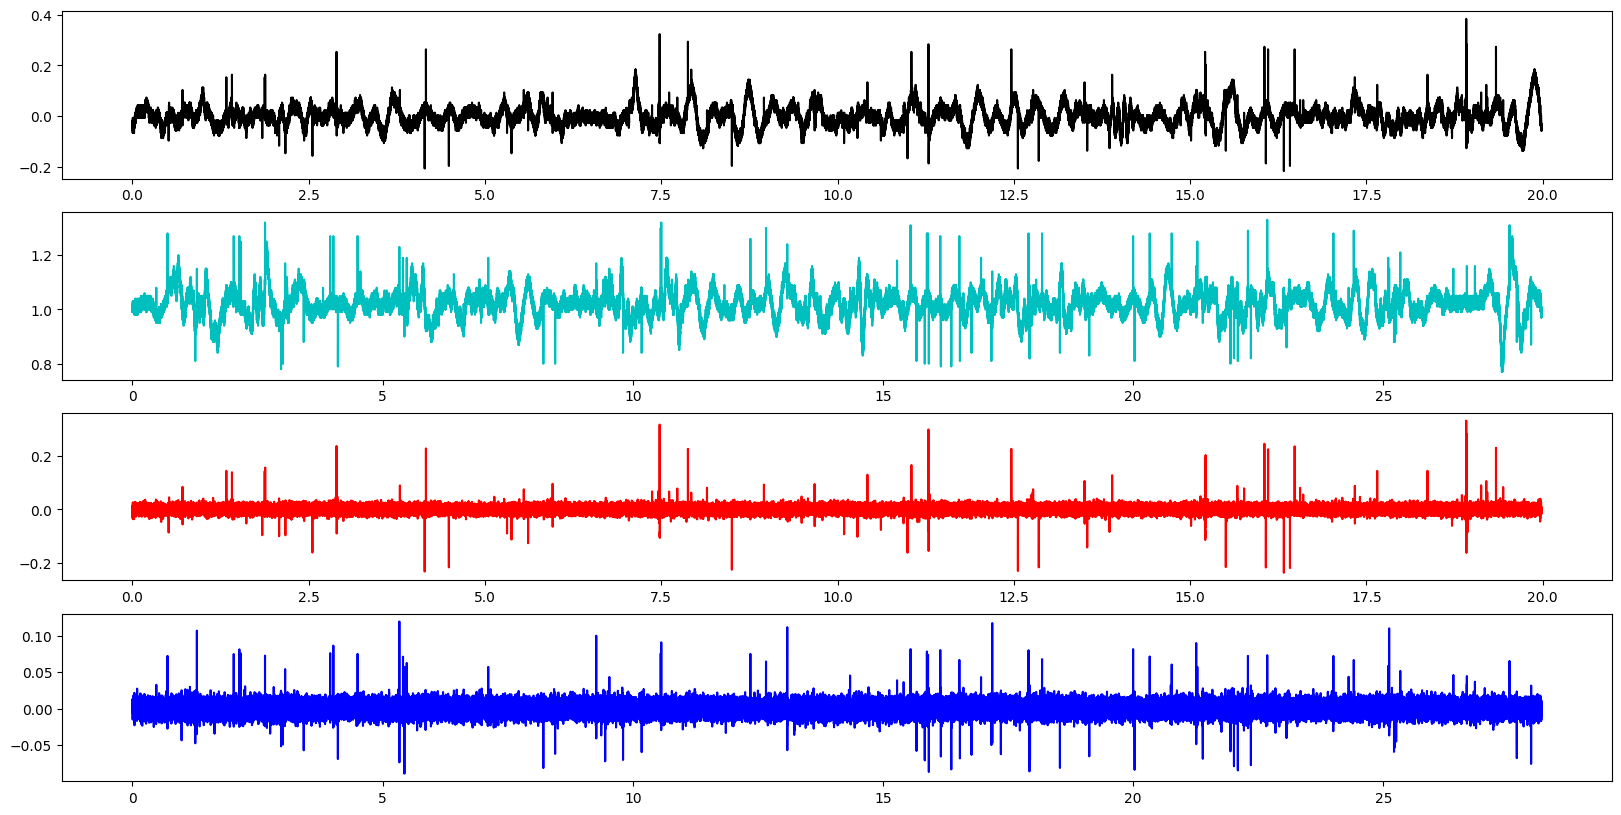

In [37]:
# simple graphs
fig, ax = plt.subplots(4,1, figsize=(20, 10))

time_step = 1 / fs  # in seconds
time = np.arange(len(op['mag'])) * time_step
time2 = np.arange(len(u_op['mag'])) * time_step
low_cut_off = 50 # removes muscle artifacts and baseline wander
high_cut_off = 1000
filter_order = 5   # 9th order has been used in literature?
filter_type =  "bandpass"  #"bandpass"
fs = 6000

op_mag_m = op['mag'] - np.mean(op['mag'])

#np.degrees(op["gyr_x"])
#ax[0].plot(time, op['mag'], color="m", label="replaced knee")
ax[0].plot(time, op_mag_m, color="black")
ax[1].plot(time2, u_op["mag"], color="c", label="mag squared")
ax[2].plot(time, op_mag, color="r")
ax[3].plot(time2, u_op_mag, color="b")

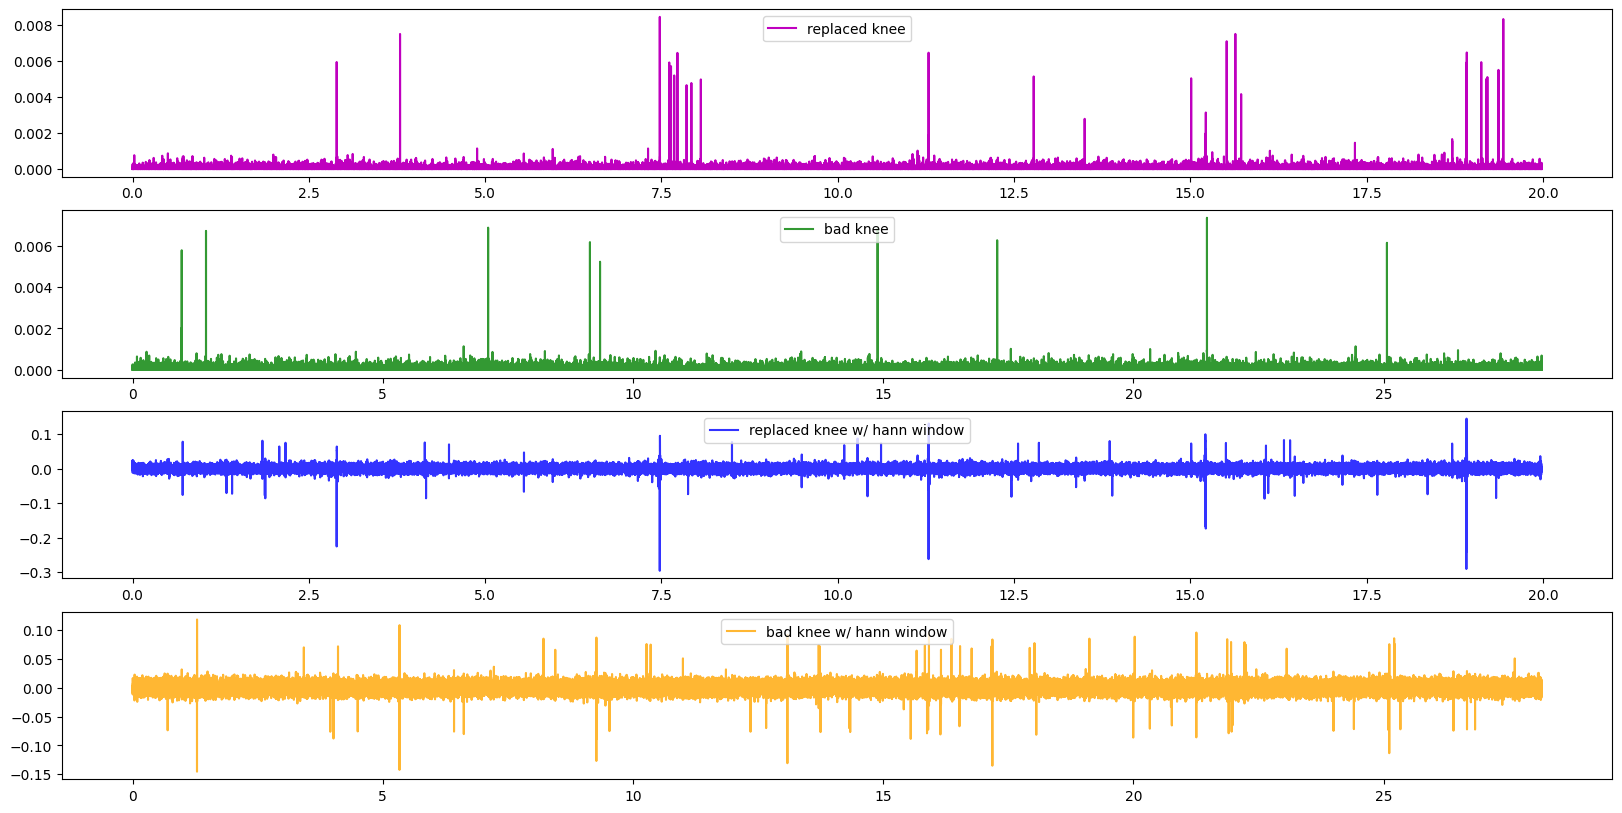

In [7]:
# plot the graphs
fig, ax = plt.subplots(4,1, figsize=(20, 10))

time_step = 1 / fs  # in seconds

# Create the time index array
time = np.arange(len(op_x)) * time_step
time2 = np.arange(len(u_op_x))* time_step

# add plots
ax[0].plot(time, op_x**2, color="m", label="replaced knee")
#ax[0].plot(time, amplitude_normal(op['x']), color="c")
ax[1].plot(time2, u_op_x**2, color="green", alpha=0.8, label="bad knee")
#ax[1].plot(time, op_x,color="red")
#ax[1].plot(time2, u_op_x, color="c")
#ax[2].plot(time, op_y, color="blue")
#ax[2].plot(time2, u_op_y, color="m")
#ax[3].plot(time, op_z, color="orange")
#ax[3].plot(time2, u_op_z)

ax[2].plot(time, op_y, color="blue", alpha=0.8, label="replaced knee w/ hann window")
ax[3].plot(time2, u_op_y, color="orange", alpha=0.8, label="bad knee w/ hann window")

ax[0].legend(loc='upper center')
ax[1].legend(loc='upper center')
ax[2].legend(loc='upper center')
ax[3].legend(loc='upper center')

# Power Spectrum
### 1. Welches method
### 2. Simple fft and square mag at each f

In [72]:
# functions
def compute_fft_mag(data, fs):
    T = 1/fs
    fftpoints = int(math.pow(2, math.ceil(math.log2(len(data)))))
    fft = np.fft.fft(data, n=fftpoints)
    mag = np.abs(fft) 
    N_r =len(mag)//2
    x = np.linspace(0.0, 1.0/(2.0*T), len(mag)//2).tolist()
    y = mag[:N_r]
    return x,y

# assumes a numpy arrray
def compute_power_spectrum(fft_mag):
    power = np.square(fft_mag)
    return power

In [73]:
# 2.simple fft

fftpoints =  len(op_mag)
op_x, op_fft = compute_fft_mag(op_mag, fs)
op_power = compute_power_spectrum(op_fft)
op_total_pwr =  round(np.sum(op_power),2)


fftpoints =  len(u_op_mag)
u_op_x, u_op_fft = compute_fft_mag(u_op_mag, fs)
u_op_power = compute_power_spectrum(u_op_fft)
u_op_total_pwr =  round(np.sum(u_op_power),2)

#fftpoints =  len(op_mag_hann)
#op_hann_fft = compute_fft_mag(op_mag_hann)
#op_hann_power = compute_power_spectrum(op_hann_fft)
#op_hann_x = np.fft.fftfreq(fftpoints, d=1/fs)

#fftpoints =  len(u_op_mag_hann)
#u_op_hann_fft = compute_fft_mag(u_op_mag_hann)
#u_op_hann_power = compute_power_spectrum(u_op_hann_fft)
#u_op_hann_x = np.fft.fftfreq(fftpoints, d=1/fs)

print(f"total pwr op:   {op_total_pwr}")
print(f"total pwr u_op: {u_op_total_pwr}")

op_int_total_pwr = np.trapezoid(op_power, op_x)
u_op_int_total_pwr = np.trapezoid(u_op_power, u_op_x)
print(op_int_total_pwr)
print(u_op_int_total_pwr)

total pwr op:   1137853.86
total pwr u_op: 4876168.87
52087.40058506446
111607.43488061245


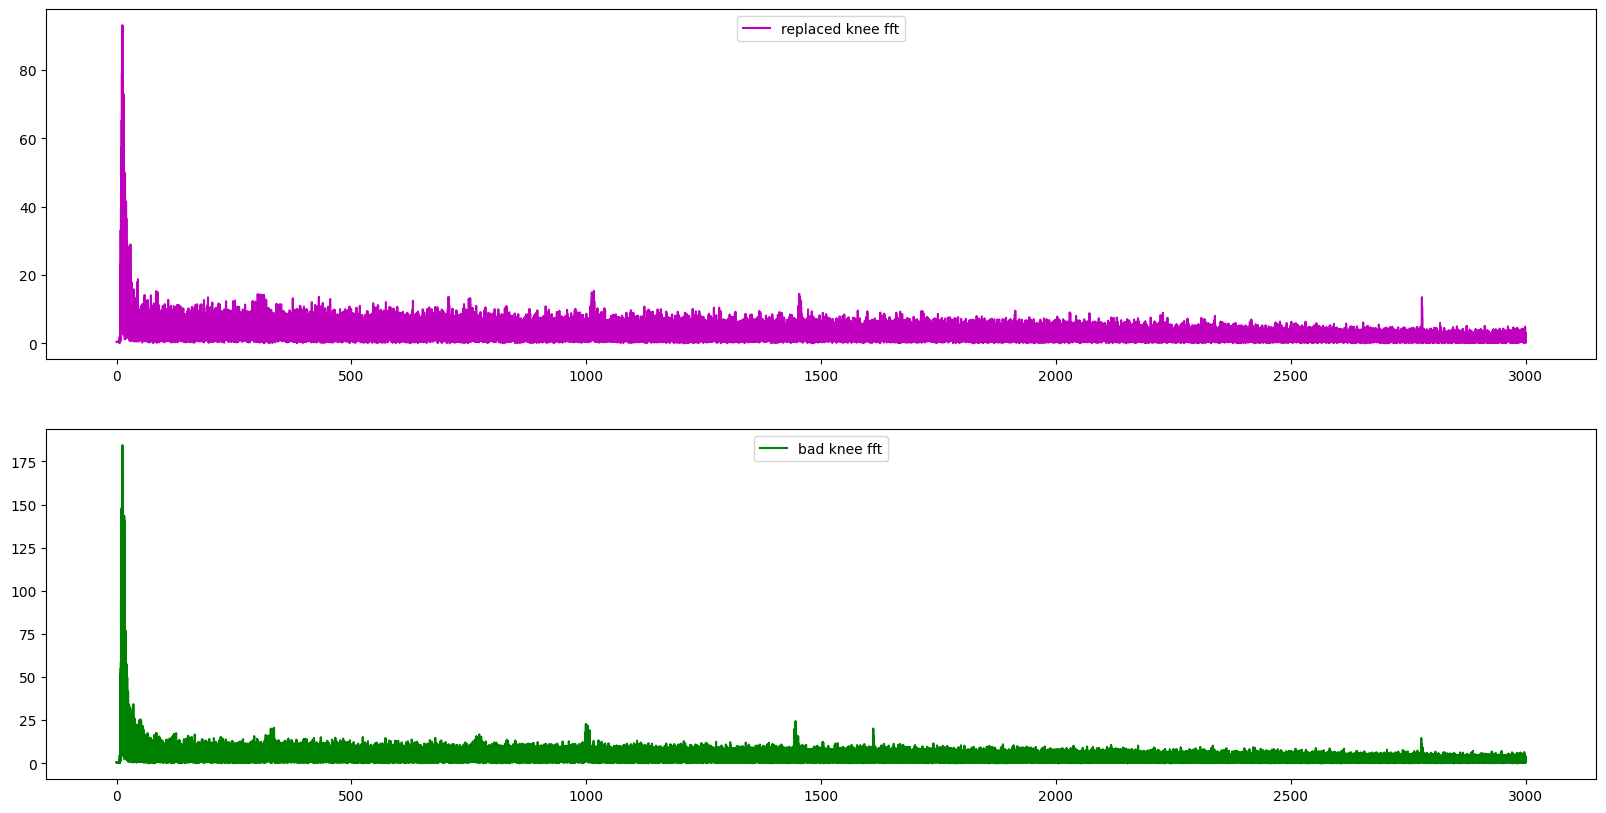

In [74]:
fig, ax = plt.subplots(2,1, figsize=(20, 10))

# add plots
ax[0].plot(op_x, op_fft, color="m", label="replaced knee fft")
ax[1].plot(u_op_x, u_op_fft, color="green", label="bad knee fft")
ax[0].legend(loc='upper center')
ax[1].legend(loc='upper center')

In [66]:
# 1 welch

segment_length = 8192 # Length of each segment
overlap = segment_length // 2  # 50% overlap
window = get_window('hann', segment_length)  # Hann window

# Compute the power spectral density or spectrum
op_w, op_psd = welch(op_mag_hann, fs=fs, window=window, nperseg=segment_length, noverlap=overlap, scaling='spectrum')
u_op_w, u_op_psd = welch(u_op_mag_hann, fs=fs, window=window, nperseg=segment_length, noverlap=overlap, scaling='spectrum')
delta_f = fs / segment_length
print(f"frequency resolution is: {delta_f}")

frequency_range = (10, 3000)  # Frequency range for normalization
op_f_idx = np.logical_and(op_w >= frequency_range[0], op_w <= frequency_range[1])
# Normalize the PSD within the desired frequency range
op_psd_norm = op_psd / np.trapezoid(op_psd[op_f_idx], op_w[op_f_idx])
u_op_f_idx = np.logical_and(u_op_w >= frequency_range[0], u_op_w <= frequency_range[1])
# Normalize the PSD within the desired frequency range
u_op_psd_norm = u_op_psd / np.trapezoid(op_psd[u_op_f_idx], u_op_w[u_op_f_idx])

op_psd_avg = np.mean(op_psd_norm, axis=0)
u_op_psd_avg = np.mean(u_op_psd_norm, axis=0)

# avg
print(f"avg psd op:    {op_psd_avg}")
print(f"avg psd u_op:  {u_op_psd_avg}")
# total power 
op_w_total_pwr = np.trapezoid(op_psd, op_w)
u_op_w_total_pwr = np.trapezoid(u_op_psd, u_op_w)

print(f"total pwr op:   {op_w_total_pwr}")
print(f"total pwr u_op: {u_op_w_total_pwr}")

op_sp_f, op_sp_t, op_Sxx = spectrogram(op_mag, fs=fs, window=window, nperseg=segment_length, noverlap=overlap, scaling='density')
u_op_sp_f, u_op_sp_t, u_op_Sxx = spectrogram(u_op_mag, fs=fs, window=window, nperseg=segment_length, noverlap=overlap, scaling='density')

frequency resolution is: 0.732421875
avg psd op:    0.00034135013419748795
avg psd u_op:  0.00044913910225347217
total pwr op:   7.886385833276102e-05
total pwr u_op: 0.00010376833610102867


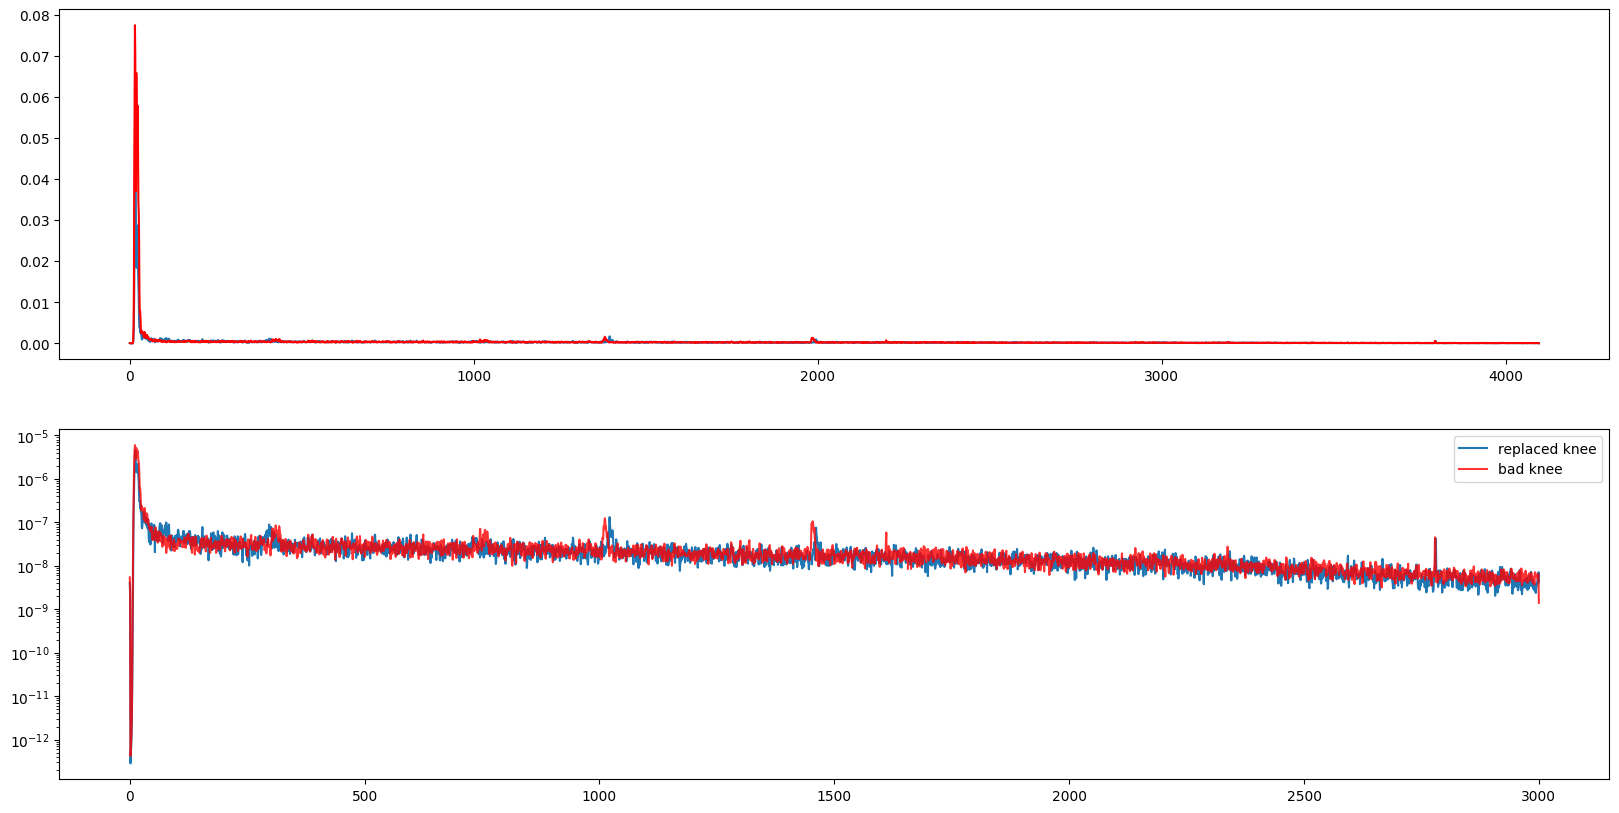

In [67]:
fig, ax = plt.subplots(2,1, figsize=(20, 10))
ax[0].plot(op_psd_norm)
ax[0].plot(u_op_psd_norm, color="r")
ax[1].semilogy(op_w, op_psd, label="replaced knee")
ax[1].semilogy(u_op_w, u_op_psd, color="r", alpha=0.8, label="bad knee")

ax[1].legend()
